In [6]:
import pickle
import sys

import jax
import jax.numpy as jnp
import jraph
import ml_collections
import yaml

sys.path.append('..')

In [2]:
import os

os.environ['CUDA_VISIBLE_DEVICES']


'7'

In [5]:
import input_pipeline
import qm9
from models import create_model, RADII

No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


In [7]:
path = "/home/ameyad/spherical-harmonic-net/workdirs/v3/mace/interactions=1/l=3/channels=32"

with open(path + "/checkpoints/params.pkl", 'rb') as f:
    params = pickle.load(f)
with open(path + "/config.yml", "rt") as config_file:
    config = yaml.unsafe_load(config_file)

assert config is not None
config = ml_collections.ConfigDict(config)

In [8]:
model = create_model(config, run_in_evaluation_mode=False)
apply_fn = jax.jit(model.apply)

In [9]:
atomic_numbers = jnp.array([1, 6, 7, 8, 9])
epsilon = 0.125  # Angstroms
cutoff = 5.0  # Angstroms
filtering_threshold = 2.0  # Angstroms

molecules = qm9.load_qm9("qm9_data")

molecule = molecules[0]
seed = jax.random.PRNGKey(0)

graph = input_pipeline.ase_atoms_to_jraph_graph(molecule, atomic_numbers, cutoff)
frags = input_pipeline.generate_fragments(seed, graph, len(atomic_numbers), epsilon)
frags = list(frags)

frag = frags[-4]


44827648it [00:04, 10242652.86it/s]                              


In [18]:
graphs = jraph.pad_with_graphs(frag, 64, 1024, 2)
pred = apply_fn(params, jax.random.PRNGKey(0), graphs)
pred = jraph.unpad_with_graphs(pred)

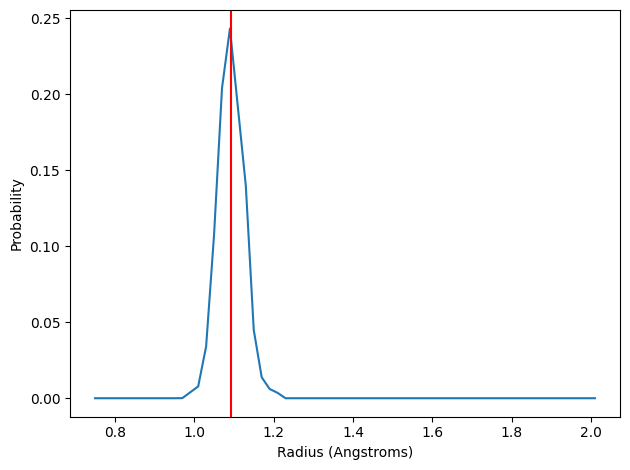

In [19]:
import matplotlib.pyplot as plt

r = frag.globals.target_positions
p = pred.globals.position_probs
p_r = p.integrate().array.squeeze()
p_r = p_r / p_r.sum()

plt.plot(RADII, p_r)
plt.axvline(jnp.linalg.norm(r), color='r')

plt.xlabel("Radius (Angstroms)")
plt.ylabel("Probability")
plt.tight_layout()
plt.show()